In [137]:
# Import packages and modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [139]:
df  = pd.read_csv("../Data/dataset_dk3619_preprocessed_v1.csv")

In [140]:
df.head()

,HourUTC,HourDK,DK3619Code,hour,day_of_week,weekday_name,quarter,month,year,day_of_year,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48
0,2020-01-01T00:00:00,2020-01-01 01:00:00,R_R,1,2,Wednesday,1,1,2020,1,...,39.452003,37.029076,34.272778,30.867796,27.691839,24.262220,21.446964,20.692560,20.760229,21.076712
1,2020-01-01T00:00:00,2020-01-01 01:00:00,Q_QB,1,2,Wednesday,1,1,2020,1,...,13.973817,13.383460,12.440164,11.175482,9.128553,7.690116,7.325366,7.297887,7.436323,7.600429
2,2020-01-01T00:00:00,2020-01-01 01:00:00,Q_QA,1,2,Wednesday,1,1,2020,1,...,9.143302,8.965540,8.633377,6.069151,3.955089,3.400593,3.144497,3.085907,3.090541,3.118976
3,2020-01-01T00:00:00,2020-01-01 01:00:00,PR_PR,1,2,Wednesday,1,1,2020,1,...,1208.678223,1180.071045,1051.362549,880.705933,789.150513,721.568359,703.513916,712.612061,736.379395,784.044617
4,2020-01-01T00:00:00,2020-01-01 01:00:00,P_P,1,2,Wednesday,1,1,2020,1,...,53.242626,53.199566,53.141167,50.922737,46.150143,42.539543,41.061405,40.467297,40.414558,40.375416


In [141]:
print(df['DK3619Code'])
dkcode_list = set(df['DK3619Code'].to_list())
id2dkcode = enumerate(dkcode_list)
id2dkcode = dict(id2dkcode)

dkcode2id = {}
for i in id2dkcode.items():
    dkcode2id[i[1]] = i[0]
print(dict(dkcode2id))

### Mapping data to numberic
# df['DK3619Code'] = df['DK3619Code'].map(dkcode2id)

0            R_R
1           Q_QB
2           Q_QA
3          PR_PR
4            P_P
           ...  
1254843      E_E
1254844      F_F
1254845      I_I
1254846      H_H
1254847      A_A
Name: DK3619Code, Length: 1254848, dtype: object
{'M_MA': 0, 'PR_PR': 1, 'F_F': 2, 'M_MC': 3, 'C_CC': 4, 'C_CA': 5, 'A_A': 6, 'N_N': 7, 'E_E': 8, 'H_H': 9, 'C_CM_CB': 10, 'Q_QA': 11, 'C_CK': 12, 'C_CH': 13, 'P_P': 14, 'I_I': 15, 'M_MB': 16, 'C_CJ': 17, 'C_CI': 18, 'C_CL': 19, 'J_JB_JC': 20, 'D_D': 21, 'Q_QB': 22, 'S_S': 23, 'C_CE_CF_CD': 24, 'R_R': 25, 'G_G': 26, 'O_O': 27, 'C_CG': 28, 'L_L': 29, 'J_JA': 30, 'K_K': 31}


### Choose Feauture will use for Model

In [142]:
columns = ['HourUTC', 'HourDK', 'hour', 'day_of_week',
              'weekday_name', 'quarter', 'month', 'year', 'day_of_year',
              'day_of_month', 'week_of_year', 'season', 'holiday', 'Consumption_MWh']


In [143]:
df.columns

Index(['HourUTC', 'HourDK', 'DK3619Code', 'hour', 'day_of_week',
       'weekday_name', 'quarter', 'month', 'year', 'day_of_year',
       'day_of_month', 'week_of_year', 'season', 'holiday', 'DK36Code',
       'DK36Title', 'DK19Code', 'DK19Title', 'Consumption_MWh', 'lag_24',
       'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31',
       'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38',
       'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45',
       'lag_46', 'lag_47', 'lag_48'],
      dtype='object')

In [144]:
print(df['weekday_name'])
weekday_list = set(df['weekday_name'].to_list())
id2day = enumerate(weekday_list)
id2day = dict(id2day)

day2id = {}
for i in id2day.items():
    day2id[i[1]] = i[0]
print(dict(day2id))

0          Wednesday
1          Wednesday
2          Wednesday
3          Wednesday
4          Wednesday
             ...    
1254843       Friday
1254844       Friday
1254845       Friday
1254846       Friday
1254847       Friday
Name: weekday_name, Length: 1254848, dtype: object
{'Monday': 0, 'Sunday': 1, 'Thursday': 2, 'Saturday': 3, 'Friday': 4, 'Wednesday': 5, 'Tuesday': 6}


In [145]:
### Mapping data to numberic
df['weekday_name'] = df['weekday_name'].map(day2id)

In [146]:
print(df['season'])
season_list = set(df['season'].to_list())
id2season = enumerate(season_list)
id2season = dict(id2season)

season2id = {}
for i in id2season.items():
    season2id[i[1]] = i[0]
print(dict(season2id))

0          Winter
1          Winter
2          Winter
3          Winter
4          Winter
            ...  
1254843    Summer
1254844    Summer
1254845    Summer
1254846    Summer
1254847    Summer
Name: season, Length: 1254848, dtype: object
{'Autumn': 0, 'Spring': 1, 'Winter': 2, 'Summer': 3}


In [147]:
### Season mapping
df['season'] = df['season'].map(season2id)

In [148]:
df.head()

,HourUTC,HourDK,DK3619Code,hour,day_of_week,weekday_name,quarter,month,year,day_of_year,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48
0,2020-01-01T00:00:00,2020-01-01 01:00:00,R_R,1,2,5,1,1,2020,1,...,39.452003,37.029076,34.272778,30.867796,27.691839,24.262220,21.446964,20.692560,20.760229,21.076712
1,2020-01-01T00:00:00,2020-01-01 01:00:00,Q_QB,1,2,5,1,1,2020,1,...,13.973817,13.383460,12.440164,11.175482,9.128553,7.690116,7.325366,7.297887,7.436323,7.600429
2,2020-01-01T00:00:00,2020-01-01 01:00:00,Q_QA,1,2,5,1,1,2020,1,...,9.143302,8.965540,8.633377,6.069151,3.955089,3.400593,3.144497,3.085907,3.090541,3.118976
3,2020-01-01T00:00:00,2020-01-01 01:00:00,PR_PR,1,2,5,1,1,2020,1,...,1208.678223,1180.071045,1051.362549,880.705933,789.150513,721.568359,703.513916,712.612061,736.379395,784.044617
4,2020-01-01T00:00:00,2020-01-01 01:00:00,P_P,1,2,5,1,1,2020,1,...,53.242626,53.199566,53.141167,50.922737,46.150143,42.539543,41.061405,40.467297,40.414558,40.375416


In [149]:
df_filter = df[df['DK3619Code'] == 'M_MA']
df_corr = df_filter[columns]
#df_corr = pd.get_dummies(df_corr, columns=['DK3619Code'], prefix=['DK3619Code'])

In [150]:
df_corr['HourUTC'] = pd.to_datetime(df_corr['HourUTC'])
df_corr['HourDK'] = pd.to_datetime(df_corr['HourDK'])

df_corr = df_corr.drop(['HourUTC', 'HourDK'], axis=1)
correlation_matrix = df_corr.corr()

print(correlation_matrix)

                     hour  day_of_week  weekday_name   quarter     month  \
hour             1.000000     0.000031      0.000007 -0.000474 -0.000381   
day_of_week      0.000031     1.000000     -0.142880  0.005113  0.002195   
weekday_name     0.000007    -0.142880      1.000000 -0.001043  0.002529   
quarter         -0.000474     0.005113     -0.001043  1.000000  0.971405   
month           -0.000381     0.002195      0.002529  0.971405  1.000000   
year             0.000003    -0.001488     -0.000045 -0.167065 -0.164858   
day_of_year     -0.000383     0.001951      0.002405  0.968419  0.996503   
day_of_month    -0.000030    -0.002681     -0.001298  0.014204  0.010564   
week_of_year    -0.000383    -0.002119     -0.000197  0.950924  0.975835   
season           0.000132    -0.001249      0.000347 -0.250823 -0.241304   
holiday          0.000427     0.024303     -0.103094 -0.039590 -0.047138   
Consumption_MWh  0.061208    -0.332120      0.150927 -0.178626 -0.165799   

           

<ipython-input-150-9541cc38cc30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['HourUTC'] = pd.to_datetime(df_corr['HourUTC'])
<ipython-input-150-9541cc38cc30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['HourDK'] = pd.to_datetime(df_corr['HourDK'])


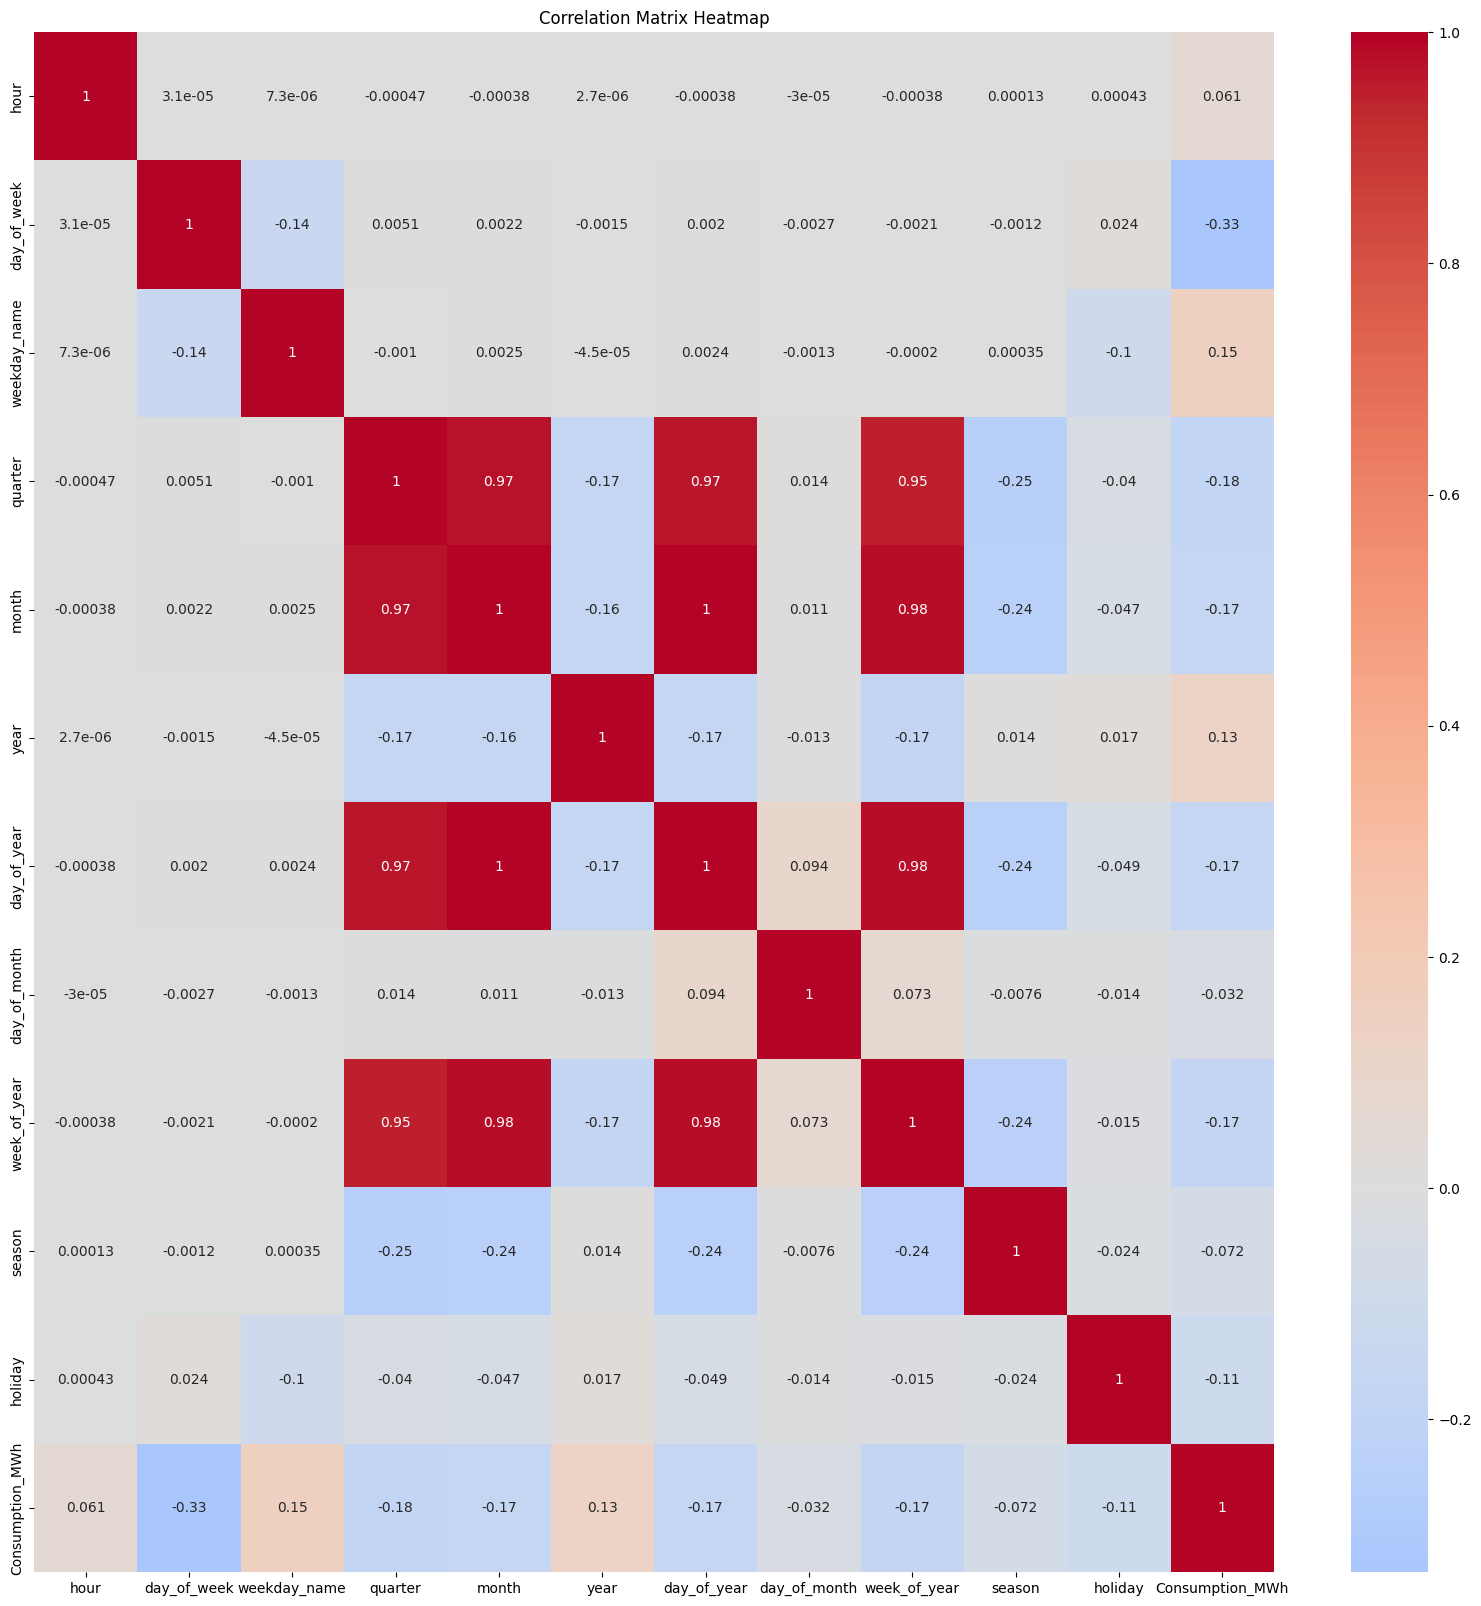

In [151]:
# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Split data

In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dense, Bidirectional
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import TimeDistributed, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [153]:
# Normalize the data
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df_corr[['season', 'year', 'month', 'hour', 'Consumption_MWh']])

scaled_df = pd.DataFrame(scaled_df, columns=['season', 'year', 'month', 'hour', 'Consumption_MWh'])

In [154]:
# Create sequences
def create_sequences(df, seq_length):
    sequences = []
    labels = []
    for i in range(len(df) - seq_length):
        seq = df.iloc[i:i+seq_length].values
        label = df['Consumption_MWh'].iloc[i+seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 24  # for 24 hours sequence
sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

In [155]:
labels

array([0.14216852, 0.14344023, 0.14076981, ..., 0.21761264, 0.24872479,
       0.30618601])

In [156]:


# Split the data into training (60%), validation (20%), and test (20%) sets
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)


In [157]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])


In [158]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [159]:
# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Model Training
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
1568/1568 [==============================] - 51s 30ms/step - loss: 0.0047 - val_loss: 0.0043 - lr: 0.0010
Epoch 2/10
1568/1568 [==============================] - 56s 36ms/step - loss: 0.0017 - val_loss: 0.0023 - lr: 0.0010
Epoch 3/10
1568/1568 [==============================] - 59s 37ms/step - loss: 0.0010 - val_loss: 0.0019 - lr: 0.0010
Epoch 4/10
1568/1568 [==============================] - 47s 30ms/step - loss: 7.2987e-04 - val_loss: 0.0019 - lr: 0.0010
Epoch 5/10
1568/1568 [==============================] - 46s 29ms/step - loss: 6.4505e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/10
1568/1568 [==============================] - 48s 31ms/step - loss: 5.9397e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 7/10
1568/1568 [==============================] - 47s 30ms/step - loss: 5.6307e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 8/10
1568/1568 [==============================] - 46s 29ms/step - loss: 5.3606e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 9/10
1568/1568 [======================

In [160]:
model.save("custom_model.keras")
model = tf.keras.models.load_model("custom_model.keras")

In [161]:
# Model Evaluation
predictions = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

245/245 [==============================] - 3s 9ms/step
R² Score: 0.8670952505861056
Mean Absolute Error (MAE): 0.03742456547856472
Mean Squared Error (MSE): 0.004411014904427267
Root Mean Squared Error (RMSE): 0.06641547187536401


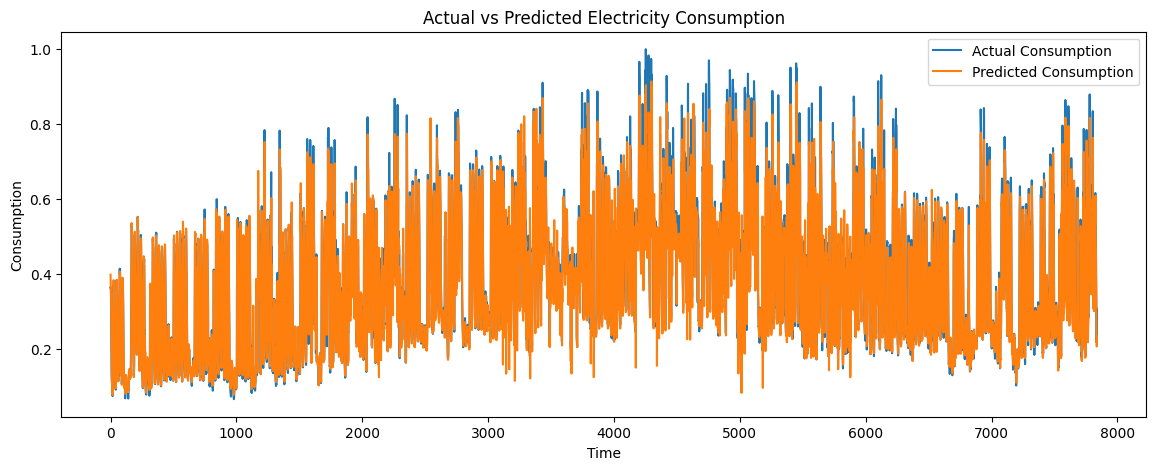

In [162]:
# Plot predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual Consumption')
plt.plot(predictions, label='Predicted Consumption')
plt.title('Actual vs Predicted Electricity Consumption')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

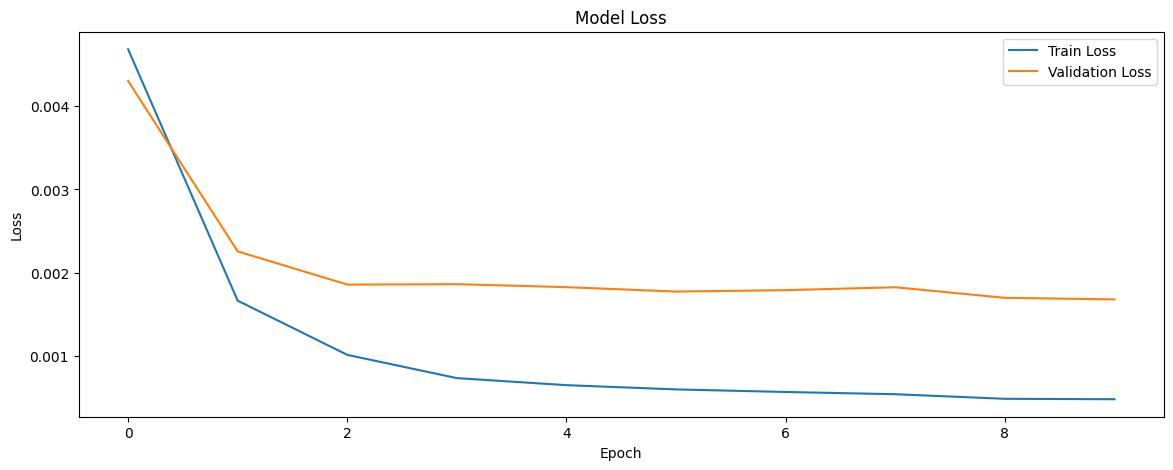

In [163]:
# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#all_dkcode_trainings
for i in dkcode_list:
    print('Training LSTM model with DKCode: ', i)
    df_filter = df[df['DK3619Code'] == i]
    df_corr = df_filter[columns]

    df_corr['HourUTC'] = pd.to_datetime(df_corr['HourUTC'])
    df_corr['HourDK'] = pd.to_datetime(df_corr['HourDK'])

    df_corr = df_corr.drop(['HourUTC', 'HourDK'], axis=1)

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df_corr[['season', 'year', 'month', 'hour', 'Consumption_MWh']])

    scaled_df = pd.DataFrame(scaled_df, columns=['season', 'year', 'month', 'hour', 'Consumption_MWh'])

    #create sequence for training
    SEQ_LENGTH = 24  # for 24 hours sequence
    sequences, labels = create_sequences(scaled_df, SEQ_LENGTH)

    # Split the data into training (60%), validation (20%), and test (20%) sets
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, shuffle=False)

    #LSTM modeling
    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    # Model Training
    history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

    model.save("../Checkpoints/" + i + "_LSTMmodel.keras")
    model = tf.keras.models.load_model("../Checkpoints/" + str(i) + "_LSTMmodel.keras")


    # Model Evaluation
    predictions = model.predict(X_test)

    # Calculate evaluation metrics
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    print(f'R² Score: {r2}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

Training LSTM model with DKCode:  M_MA


<ipython-input-167-99141f735f04>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['HourUTC'] = pd.to_datetime(df_corr['HourUTC'])
<ipython-input-167-99141f735f04>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['HourDK'] = pd.to_datetime(df_corr['HourDK'])


Epoch 1/10
1568/1568 [==============================] - 52s 30ms/step - loss: 0.0045 - val_loss: 0.0031 - lr: 0.0010
Epoch 2/10
1568/1568 [==============================] - 47s 30ms/step - loss: 0.0016 - val_loss: 0.0022 - lr: 0.0010
Epoch 3/10
1568/1568 [==============================] - 45s 29ms/step - loss: 9.6928e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 4/10
1568/1568 [==============================] - 47s 30ms/step - loss: 7.2270e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/10
1568/1568 [==============================] - 46s 29ms/step - loss: 6.2837e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/10
1568/1568 [==============================] - 46s 29ms/step - loss: 5.8129e-04 - val_loss: 0.0018 - lr: 0.0010
Epoch 7/10
 953/1568 [=================>............] - ETA: 17s - loss: 5.6263e-04